In [1]:
# !pip install --upgrade torch-scatter
# !pip install --upgrade torch-sparse
# !pip install --upgrade torch-cluster
# !pip install --upgrade torch-spline-conv
!pip install torch-geometric
# 39 minutes

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
# from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv, Sequential, Linear
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch import nn

In [3]:
import random
graphs = []
for i in range(1000):
  n = random.randint(5,100)
  p = random.random()
  g = nx.erdos_renyi_graph(n = n, p = 0.25, seed = 44)
  graphs.append(g)

In [4]:
len(list(graphs[4].nodes))

59

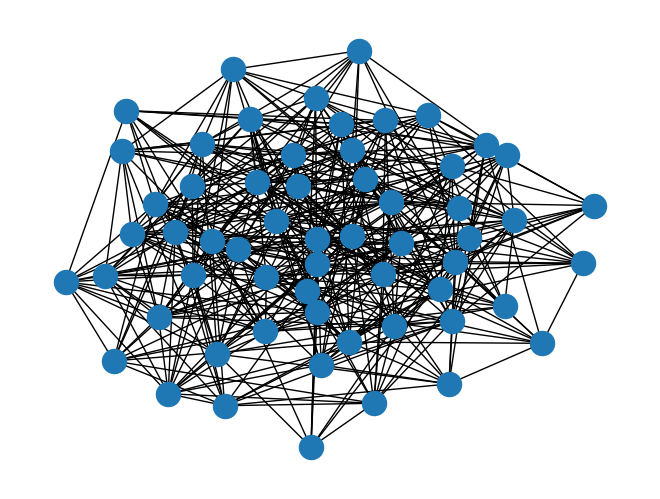

In [5]:
import matplotlib.pyplot as plt
nx.draw(graphs[4])
plt.show()

In [6]:
features = []
labels_bc = []
labels_ec = []
labels_pc = []

for G in graphs:
    bc = nx.betweenness_centrality(G)
    ec = nx.eigenvector_centrality(G)
    pc = nx.pagerank(G)

    for node in G.nodes():
        feature = np.random.rand(32)
        label_bc = bc[node]
        label_ec = ec[node]
        label_pc = pc[node]

        features.append(feature)
        labels_bc.append(label_bc)
        labels_ec.append(label_ec)
        labels_pc.append(label_pc)

In [7]:
features = torch.Tensor(features)
labels_bc = torch.Tensor(labels_bc)
labels_ec = torch.Tensor(labels_ec)
labels_pc = torch.Tensor(labels_pc)

<ipython-input-7-7c42cf00fca0>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  features = torch.Tensor(features)


In [8]:
edges = []
for G in graphs:
    num_edges = G.number_of_edges()
    for i, edge in enumerate(G.edges()):
        src = edge[0]
        dst = edge[1]
        edges.append((src, dst))
edges = np.array(edges, dtype=np.int64)

edge_index = torch.from_numpy(edges.T).contiguous()

print(edge_index)

tensor([[0, 0, 0,  ..., 3, 4, 5],
        [4, 5, 6,  ..., 7, 6, 7]])


In [9]:
class MyModel(torch.nn.Module):
    def __init__(self, num_features=32, num_classes=3):
        super(MyModel, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc1 = Linear(16, 64)
        self.fc2 = Linear(64, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [10]:
# Concatenate labels into a single 2D array
labels = np.column_stack((labels_bc, labels_ec, labels_pc))

# Define k-fold cross validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [11]:
features = np.array(features)
labels_bc = np.array(labels_bc)
labels_ec = np.array(labels_ec)
labels_pc = np.array(labels_pc)

In [12]:
# Define model and optimizer
model = MyModel(num_classes=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define loss function
criterion = nn.MSELoss()

# Train and evaluate model using k-fold cross validation
train_losses = []
test_losses = []
for fold, (train_idx, test_idx) in enumerate(kf.split(features)):
    print("Fold:", fold+1)
    # Split data into train and test sets
    train_features = torch.tensor([features[i] for i in train_idx], dtype=torch.float32)
    train_labels_bc = torch.tensor([labels_bc[i] for i in train_idx], dtype=torch.float32)
    train_labels_ec = torch.tensor([labels_ec[i] for i in train_idx], dtype=torch.float32)
    train_labels_pc = torch.tensor([labels_pc[i] for i in train_idx], dtype=torch.float32)

    test_features = torch.tensor([features[i] for i in test_idx], dtype=torch.float32)
    test_labels_bc = torch.tensor([labels_bc[i] for i in test_idx], dtype=torch.float32)
    test_labels_ec = torch.tensor([labels_ec[i] for i in test_idx], dtype=torch.float32)
    test_labels_pc = torch.tensor([labels_pc[i] for i in test_idx], dtype=torch.float32)

    # Train model
    epochs = 50
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(train_features, edge_index)
        loss_bc = criterion(out[:,0], train_labels_bc)
        loss_ec = criterion(out[:,1], train_labels_ec)
        loss_pc = criterion(out[:,2], train_labels_pc)
        loss = loss_bc + loss_ec + loss_pc
        loss.backward()
        optimizer.step()

        # Evaluate model on test set
        with torch.no_grad():
            out = model(test_features, edge_index)
            test_loss_bc = criterion(out[:,0], test_labels_bc).item()
            test_loss_ec = criterion(out[:,1], test_labels_ec).item()
            test_loss_pc = criterion(out[:,2], test_labels_pc).item()

        train_losses.append(loss.item())
        test_losses.append((test_loss_bc, test_loss_ec, test_loss_pc))
        if(epoch%10 == 0):
          print("Epoch: {:03d}, Train Loss: {:.4f}, Test Loss (BC/EC/PC): {:.4f}/{:.4f}/{:.4f}".format(epoch, loss.item(), test_loss_bc, test_loss_ec, test_loss_pc))

# Compute average performance across all folds
avg_train_loss = sum(train_losses) / len(train_losses)
avg_test_loss_bc = sum([test_loss[0] for test_loss in test_losses]) / len(test_losses)
avg_test_loss_ec = sum([test_loss[1] for test_loss in test_losses]) / len(test_losses)
avg_test_loss_pc = sum([test_loss[2] for test_loss in test_losses]) / len(test_losses)


Fold: 1
Epoch: 000, Train Loss: 0.0329, Test Loss (BC/EC/PC): 0.0249/0.1724/0.0172
Epoch: 010, Train Loss: 0.0058, Test Loss (BC/EC/PC): 0.0042/0.0029/0.0023
Epoch: 020, Train Loss: 0.0039, Test Loss (BC/EC/PC): 0.0007/0.0033/0.0006
Epoch: 030, Train Loss: 0.0036, Test Loss (BC/EC/PC): 0.0007/0.0027/0.0007
Epoch: 040, Train Loss: 0.0036, Test Loss (BC/EC/PC): 0.0010/0.0029/0.0003
Fold: 2
Epoch: 000, Train Loss: 0.0035, Test Loss (BC/EC/PC): 0.0022/0.0034/0.0004
Epoch: 010, Train Loss: 0.0034, Test Loss (BC/EC/PC): 0.0020/0.0032/0.0004
Epoch: 020, Train Loss: 0.0034, Test Loss (BC/EC/PC): 0.0018/0.0031/0.0004
Epoch: 030, Train Loss: 0.0034, Test Loss (BC/EC/PC): 0.0017/0.0032/0.0004
Epoch: 040, Train Loss: 0.0034, Test Loss (BC/EC/PC): 0.0017/0.0031/0.0004
Fold: 3
Epoch: 000, Train Loss: 0.0035, Test Loss (BC/EC/PC): 0.0007/0.0026/0.0004
Epoch: 010, Train Loss: 0.0035, Test Loss (BC/EC/PC): 0.0007/0.0026/0.0004
Epoch: 020, Train Loss: 0.0035, Test Loss (BC/EC/PC): 0.0007/0.0026/0.0003
E

In [13]:
print("Train Loss: {:.4f}, Test Loss (BC/EC/PC): {:.4f}/{:.4f}/{:.4f}".format(avg_train_loss, avg_test_loss_bc, avg_test_loss_ec, avg_test_loss_pc))

Train Loss: 0.0038, Test Loss (BC/EC/PC): 0.0010/0.0034/0.0005


In [14]:
# Generate random graph
n_nodes = 1000
p = 0.05
graph = nx.fast_gnp_random_graph(n_nodes, p)

# Generate features
n_features = 32
features = np.random.randn(n_nodes, n_features)

# Generate edge indices
edge_index = np.array(graph.edges()).T

# Convert to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Forward pass through model
model.eval()
with torch.no_grad():
    output = model(features, edge_index)

print(output)

tensor([[-0.0180,  0.1252,  0.0529],
        [ 0.0013,  0.1763,  0.0712],
        [-0.0353,  0.1462,  0.1013],
        ...,
        [ 0.0124,  0.1437,  0.0346],
        [ 0.0166,  0.1317,  0.0271],
        [ 0.0168,  0.1315,  0.0241]])


In [15]:
betweenness = nx.betweenness_centrality(graph)
eigenvector = nx.eigenvector_centrality(graph)
pagerank = nx.pagerank(graph)

centralities = []
for node in graph.nodes():
  label_bc = betweenness[node]
  label_ec = eigenvector[node]
  label_pc = pagerank[node]
  centralities.append([label_bc,label_ec,label_pc])

In [16]:
output = output.tolist()

In [17]:
len(output)

1000

In [18]:
loss = 0
# losses = []
for i in range(1000):
  loss = loss + abs(output[i][0] - centralities[i][0])
  loss = loss + abs(output[i][1] - centralities[i][1])
  loss = loss + abs(output[i][2] - centralities[i][2])
  # losses.append(loss)
  # print(loss, centralities[i][2], output[i][2])


In [19]:
loss/1000

0.1567614095406429

In [20]:
torch.save(model.state_dict(), 'model.pth')